# RBF Network for Function Approximation
**Student Name:** Amir Hossein Sabri
**Student ID:** 40405184

## 1. Import Libraries and Load Data
In this step, we import the necessary libraries (`numpy`, `matplotlib`, `sklearn`) and load the dataset.
* The dataset `rbf_dataset.npy` contains 200 samples of a 1D non-linear function with noise.
* We separate the data into Inputs ($X$) and Outputs ($y$).

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

# Load the dataset
# Ensure 'rbf_dataset.npy' is uploaded to your Colab environment
try:
    data = np.load('rbf_dataset.npy')
except FileNotFoundError:
    print("Error: File 'rbf_dataset.npy' not found. Please upload it.")
    # Fallback to dummy data to prevent crash if file is missing
    data = np.zeros((200, 2))

# Separate Inputs (X) and Outputs (y)
X = data[:, 0].reshape(-1, 1)
y = data[:, 1].reshape(-1, 1)

print(f"Data Loaded. Shape: {data.shape}")

Data Loaded. Shape: (200, 2)


## 2. Visualize Raw Data
Before training, we visualize the dataset to understand the underlying non-linear function.
* The scatter plot shows the noisy samples.
* Our goal is to approximate the underlying function $y = \sin(2\pi x)$ using an RBF network.

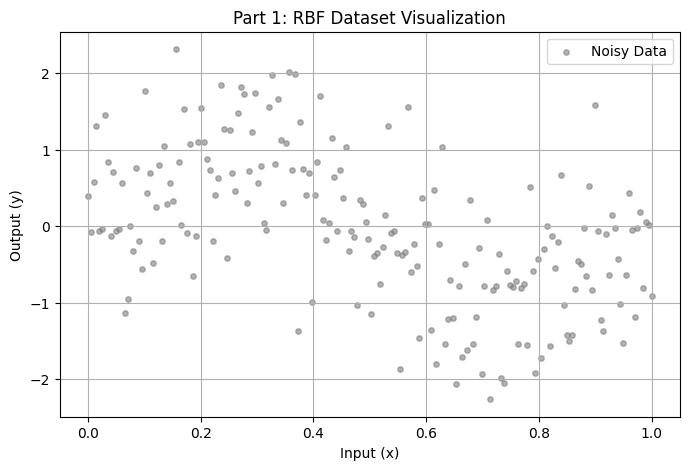

In [3]:
# Sort X for cleaner plotting later
X_sorted_idx = np.argsort(X.flatten())
X_sorted = X[X_sorted_idx]

# Plot Raw Data
plt.figure(figsize=(8, 5))
plt.scatter(X, y, s=15, c='gray', alpha=0.6, label='Noisy Data')
plt.title("Part 1: RBF Dataset Visualization")
plt.xlabel("Input (x)")
plt.ylabel("Output (y)")
plt.legend()
plt.grid(True)
plt.show()

## 3. RBF Network Implementation
Here we define the `RBFNetwork` class from scratch.
* **Centers ($c_i$):** Selected using K-Means clustering to place neurons in dense data regions.
* **Widths ($\sigma_i$):** Calculated based on the average distance to nearest neighbors (heuristic).
* **Design Matrix ($\Phi$):** Constructed using Gaussian activation functions $\varphi_i(x) = \exp(-\frac{(x-c_i)^2}{2\sigma_i^2})$.
* **Weights ($w$):** Solved using the Least Squares method ($w = (\Phi^T\Phi)^{-1}\Phi^T y$).

In [4]:
class RBFNetwork:
    def __init__(self, n_neurons, sigma_scale=1.0):
        self.k = n_neurons            # Number of RBF neurons (centers)
        self.sigma_scale = sigma_scale # Factor to adjust width (sigma)
        self.centers = None
        self.widths = None
        self.w = None                 # Output weights

    def _gaussian(self, x, c, s):
        """Gaussian RBF Function"""
        return np.exp(-np.square(x - c) / (2 * np.square(s)))

    def fit(self, X, y):
        # 1. Select Centers using K-Means
        kmeans = KMeans(n_clusters=self.k, random_state=42, n_init=10).fit(X)
        self.centers = kmeans.cluster_centers_

        # 2. Calculate Widths (Sigma)
        # We use the average distance to the 2 nearest centers as a heuristic
        dists = cdist(self.centers, self.centers)
        np.fill_diagonal(dists, np.inf)
        nearest_dists = np.sort(dists, axis=1)[:, :2]
        base_sigma = np.mean(nearest_dists, axis=1)

        # Apply scaling and handle zeros
        self.widths = base_sigma * self.sigma_scale
        self.widths[self.widths == 0] = 1.0

        # 3. Calculate Design Matrix (Phi)
        Phi = self._get_design_matrix(X)

        # 4. Calculate Weights using Pseudo-Inverse (Least Squares)
        self.w = np.linalg.pinv(Phi) @ y

    def _get_design_matrix(self, X):
        N = X.shape[0]
        Phi = np.zeros((N, self.k))
        for i in range(self.k):
            Phi[:, i] = self._gaussian(X.flatten(), self.centers[i], self.widths[i])
        return Phi

    def predict(self, X):
        Phi = self._get_design_matrix(X)
        return Phi @ self.w

## 4. Effect of Neuron Count (Underfitting vs. Overfitting)
We train the network with **5**, **15**, and **40** neurons to analyze model capacity.
* **5 Neurons:** Likely to Underfit (cannot capture the complexity).
* **15 Neurons:** Expected to fit well.
* **40 Neurons:** Risk of Overfitting (fitting the noise instead of the function).

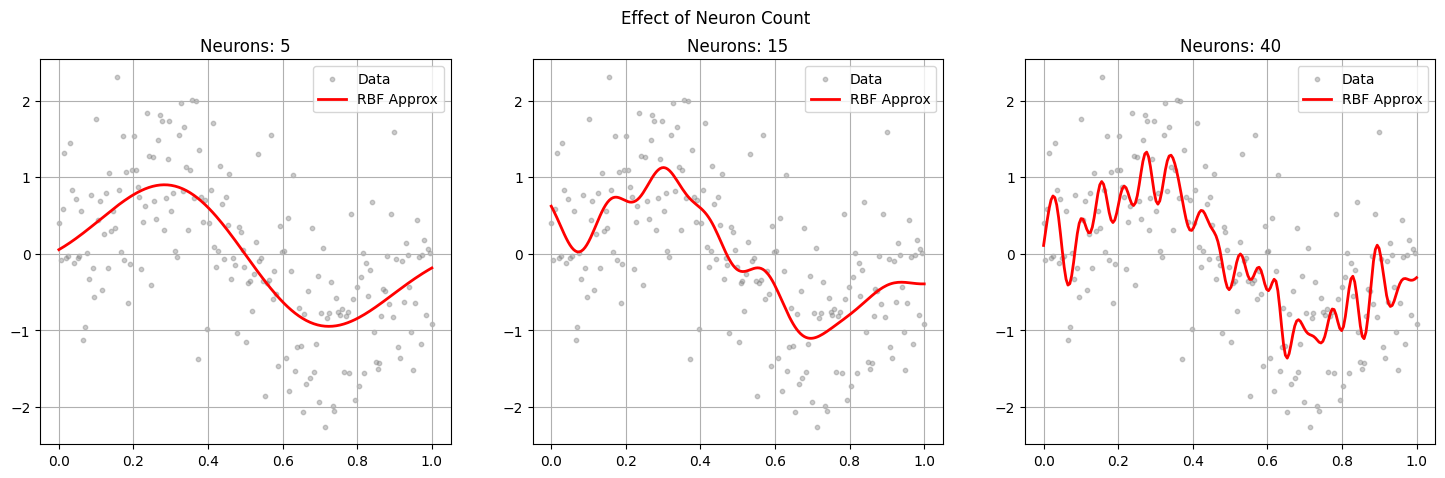

In [5]:
neuron_counts = [5, 15, 40]
plt.figure(figsize=(18, 5))

for i, k in enumerate(neuron_counts):
    # Train RBF
    rbf = RBFNetwork(n_neurons=k, sigma_scale=1.0)
    rbf.fit(X, y)
    y_pred = rbf.predict(X_sorted)

    # Plot
    plt.subplot(1, 3, i+1)
    plt.scatter(X, y, s=10, c='gray', alpha=0.4, label='Data')
    plt.plot(X_sorted, y_pred, 'r-', linewidth=2, label='RBF Approx')
    plt.title(f'Neurons: {k}')
    plt.legend()
    plt.grid(True)

plt.suptitle("Effect of Neuron Count")
plt.show()

## 5. Effect of Sigma (RBF Width)
We keep the number of neurons fixed (e.g., 20) and vary the width parameter $\sigma$.
* **Small Sigma (0.3):** Localized spikes; the function looks bumpy (overfitting/not smooth).
* **Medium Sigma (1.0):** Balanced smoothness.
* **Large Sigma (3.0):** The function becomes too smooth and may fail to capture local variations (underfitting).

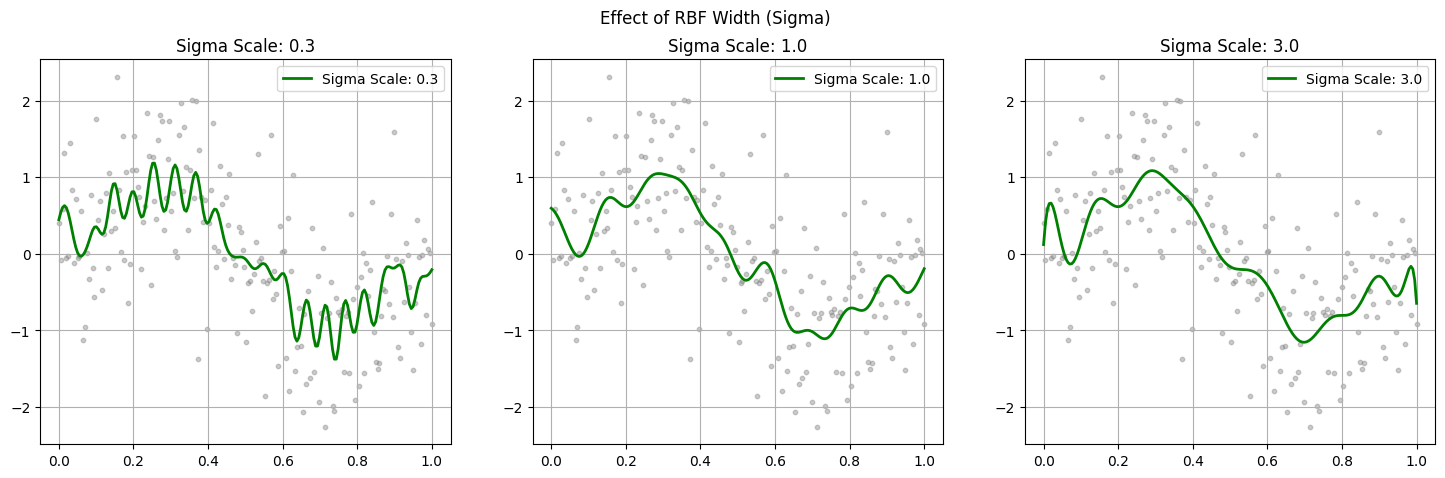

In [6]:
fixed_k = 20
sigma_scales = [0.3, 1.0, 3.0]

plt.figure(figsize=(18, 5))

for i, s in enumerate(sigma_scales):
    # Train RBF
    rbf = RBFNetwork(n_neurons=fixed_k, sigma_scale=s)
    rbf.fit(X, y)
    y_pred = rbf.predict(X_sorted)

    # Plot
    plt.subplot(1, 3, i+1)
    plt.scatter(X, y, s=10, c='gray', alpha=0.4)
    plt.plot(X_sorted, y_pred, 'g-', linewidth=2, label=f'Sigma Scale: {s}')
    plt.title(f'Sigma Scale: {s}')
    plt.legend()
    plt.grid(True)

plt.suptitle("Effect of RBF Width (Sigma)")
plt.show()

## 6. Feature Space Analysis
Here we visualize the activation of individual RBF neurons. Each curve represents the Gaussian response of a single neuron to the input space. The final output is a weighted sum of these curves.

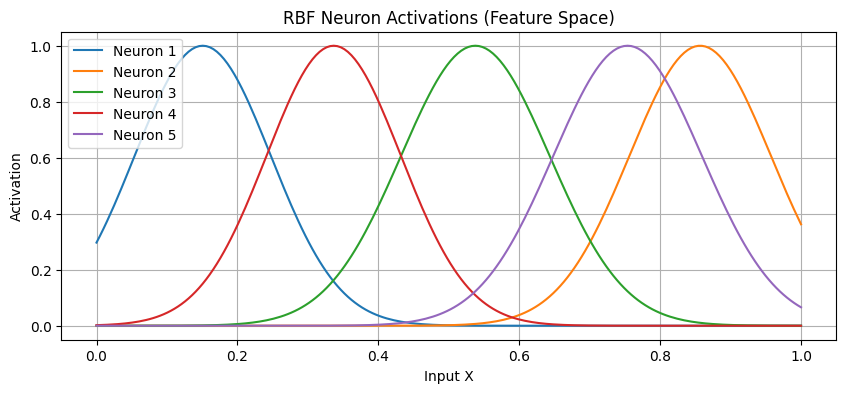

In [7]:
rbf_demo = RBFNetwork(n_neurons=10)
rbf_demo.fit(X, y)
Phi_demo = rbf_demo._get_design_matrix(X_sorted)

plt.figure(figsize=(10, 4))
for i in range(5): # Plot first 5 neurons
    plt.plot(X_sorted, Phi_demo[:, i], label=f'Neuron {i+1}')
plt.title("RBF Neuron Activations (Feature Space)")
plt.xlabel("Input X")
plt.ylabel("Activation")
plt.legend()
plt.grid(True)
plt.show()